In [1]:
from polls import *
from UKGE import *
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
run_sim(res_path="outputs/resultsclusteredconstituencies.csv",output_path="outputs/results/Results_")

BigStd:  0.11871846200612296


/home/john/Desktop/Politics/UKGE/UKGE.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rand_df[p+"Seats"] = rand_df[[c + "Winner" for c in constituencies]].eq(p).sum(1)
/home/john/Desktop/Politics/UKGE/UKGE.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  rand_df[p+"Seats"] = rand_df[[c + "Winner" for c in constituencies]].eq(p).sum(1)
/home/john/Desktop/Politics/UKGE/UKGE.py:158: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [30]:
def create_output2(results_path = "UKGE/outputs/results/Results_"):
    today = datetime.date.today()
    df = pd.read_csv(results_path+str(today)+".csv")
    df = df.transpose()
    df.columns = df.loc["Unnamed: 0"]
    df = df.drop("Unnamed: 0")
    seat_cols = ["conSeats","labSeats","libSeats","refSeats","natSeats","othSeats"]
    df[seat_cols] = df[seat_cols].astype(int)
    sims = len(df)
    reasonable_res = ["lab", "Hung Parliament: Largest Party lab", "Hung Parliament: Largest Party con", "con"]
    res_dict = {}
    for res in reasonable_res:
        res_dict[res] = [df["Result"].value_counts()[res] / sims]
    med_df = df[(df["conSeats"]>df["conSeats"].quantile(0.48))&(df["conSeats"]<df["conSeats"].quantile(0.52))&(df["labSeats"]>df["labSeats"].quantile(0.35))&(df["labSeats"]<df["labSeats"].quantile(0.65))]
    # print(med_df)
    return med_df
    # print(med_df["refSeats"])
    # typical_run = med_df[(med_df["natSeats"]>med_df["natSeats"].quantile(0.2))&(med_df["natSeats"]<med_df["natSeats"].quantile(0.8))&(med_df["libSeats"]>med_df["libSeats"].quantile(0.3))&(med_df["libSeats"]<med_df["libSeats"].quantile(0.7))&(med_df["refSeats"]>med_df["refSeats"].quantile(0.2))&(med_df["refSeats"]<med_df["refSeats"].quantile(0.8))].copy()
    # print(med_df[med_df["refSeats"]<med_df["refSeats"].quantile(0.8)])
    # print(typical_run)
    # for c in seat_cols:
    #     res_dict[c] = [typical_run.iloc[0][c]]
    # # Add Poll of Polls
    # polls = get_weighted_poll_avg(next_url, col_dict=next_col_dict)
    # for p in polls.keys():
    #     res_dict[p] = [round(polls[p],ndigits=3)]
    # today_df = pd.DataFrame(res_dict).rename({0:str(datetime.date.today())}).transpose()
    # # today_df.to_csv("UKGE/outputs/EXPORT.csv")
    # return today_df

In [12]:
def create_output3(results_path = "UKGE/outputs/results/Results_"):
    today = datetime.date.today()
    df = pd.read_csv(results_path+str(today)+".csv")
    df = df.transpose()
    df.columns = df.loc["Unnamed: 0"]
    df = df.drop("Unnamed: 0")
    seat_cols = ["conSeats","labSeats","libSeats","refSeats","natSeats","othSeats"]
    df[seat_cols] = df[seat_cols].astype(int)
    sims = len(df)
    reasonable_res = ["lab", "Hung Parliament: Largest Party lab", "Hung Parliament: Largest Party con", "con"]
    res_dict = {}
    for res in reasonable_res:
        res_dict[res] = [df["Result"].value_counts()[res] / sims]
    med_df = df[(df["conSeats"]>df["conSeats"].quantile(0.48))&(df["conSeats"]<df["conSeats"].quantile(0.52))&(df["labSeats"]>=df["labSeats"].quantile(0.48))&(df["labSeats"]<=df["labSeats"].quantile(0.52))]
    print(len(med_df))
    typical_run = med_df[(med_df["natSeats"]>=med_df["natSeats"].quantile(0.3))&(med_df["natSeats"]<=med_df["natSeats"].quantile(0.7))&(med_df["libSeats"]>=med_df["libSeats"].quantile(0.3))&(med_df["libSeats"]<=med_df["libSeats"].quantile(0.7))&(med_df["refSeats"]>=med_df["refSeats"].quantile(0.3))&(med_df["refSeats"]<=med_df["refSeats"].quantile(0.7))].copy()
    print(len(typical_run))
    for c in seat_cols:
        res_dict[c] = [typical_run.iloc[0][c]]
    # Add Poll of Polls
    polls = get_weighted_poll_avg(next_url, col_dict=next_col_dict)
    for p in polls.keys():
        res_dict[p] = [round(polls[p],ndigits=3)]
    today_df = pd.DataFrame(res_dict).rename({0:str(datetime.date.today())}).transpose()
    # today_df.to_csv("UKGE/outputs/EXPORT.csv")
    return today_df

In [4]:
today = int(datetime.date.today().strftime("%d%m%Y%H%M%S"))+1
rng = np.random.default_rng(seed=today)
rng.normal(0.1, 0.05, 100)
# np.random.normal(0.1,0.05,100)

array([ 0.09607332,  0.13709753,  0.01638142,  0.05873396,  0.25109933,
       -0.00208768,  0.06889046,  0.04121222,  0.11789883,  0.17812415,
        0.08267284,  0.0907682 ,  0.0971673 ,  0.05281598,  0.09481079,
        0.17128878,  0.14228819,  0.12975698,  0.12830181,  0.16647799,
        0.15111653,  0.11093834,  0.06529126,  0.07095712,  0.13829401,
        0.09770628,  0.05421295,  0.0679084 ,  0.11075158,  0.11200268,
        0.11109283, -0.01347307,  0.03782544,  0.16304419,  0.13464515,
        0.1051446 ,  0.16104927,  0.01792512,  0.08849205,  0.14438018,
        0.0905156 ,  0.15006076, -0.01679943,  0.15022884,  0.1358799 ,
        0.18343575,  0.11789046,  0.13244582,  0.05396117,  0.09114698,
       -0.01542495,  0.09574436,  0.06113792,  0.19949462,  0.14889249,
        0.0153327 ,  0.13307901,  0.06684488,  0.11491616,  0.05519544,
        0.09737558,  0.1536148 ,  0.06482626,  0.09624634,  0.11079501,
        0.02949193,  0.15977294,  0.15012051,  0.06982184, -0.00

In [5]:
datetime.date.today().strftime("%d%m%Y%H")

'0803202400'

In [13]:
create_output3(results_path="outputs/results/Results_")

/tmp/ipykernel_8757/3159155963.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,

12
3


,2024-03-07
lab,0.5940
Hung Parliament: Largest Party lab,0.2095
Hung Parliament: Largest Party con,0.1030
con,0.0910
conSeats,196.0000
labSeats,346.0000
libSeats,32.0000
refSeats,0.0000
natSeats,55.0000
othSeats,3.0000


        con       lab       lib       ref       nat       oth
0  0.459989  0.339228  0.121784  0.021223  0.045984  0.011793
BigStd:  0.11784594812633864
SmallStd:  0.09236148703158466
con     0   -0.221989
Name: con, dtype: float64


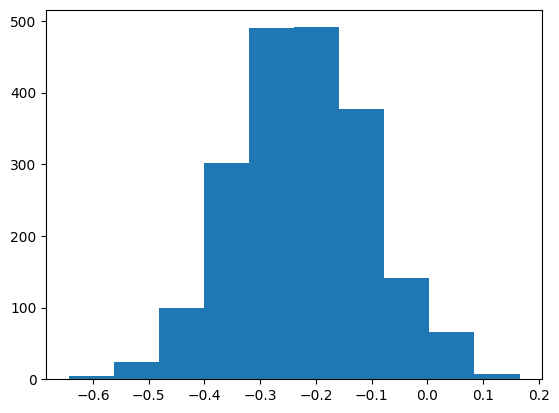

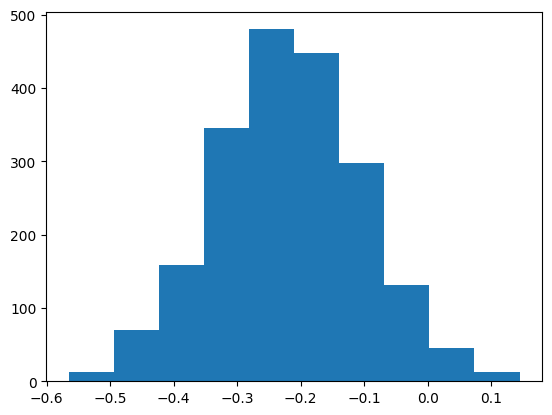

lab     0    0.097606
Name: lab, dtype: float64


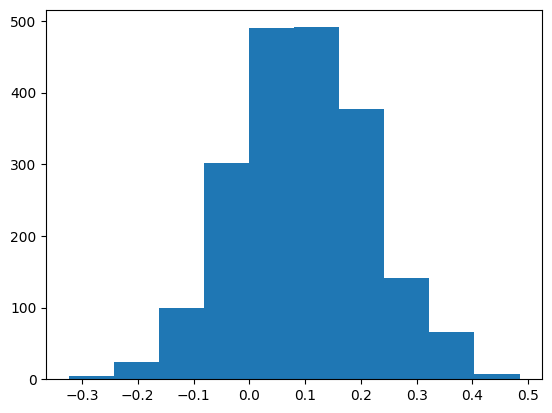

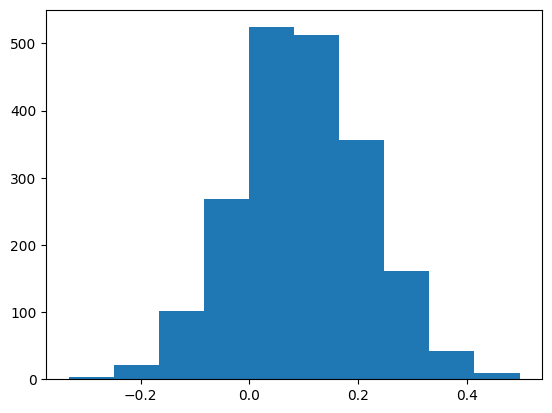

lib     0   -0.027117
Name: lib, dtype: float64


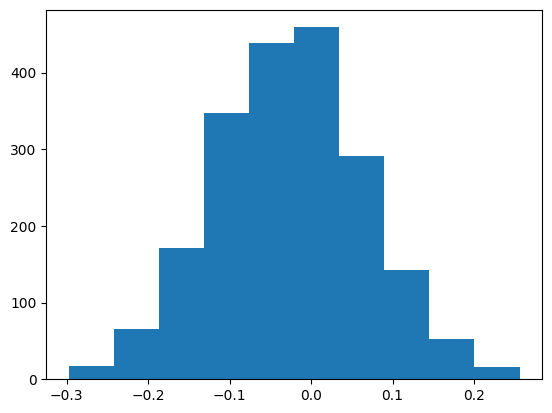

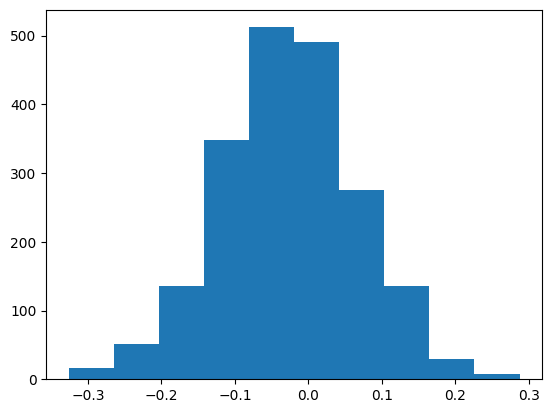

ref     0    0.092944
Name: ref, dtype: float64


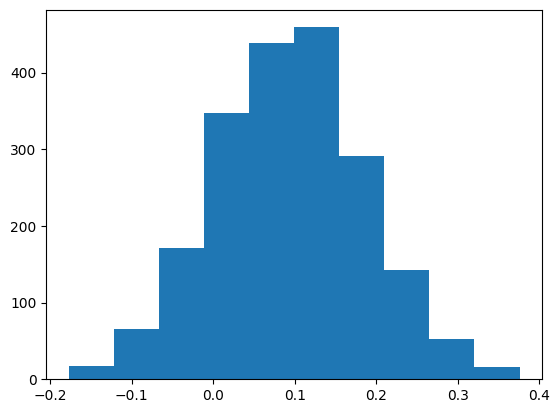

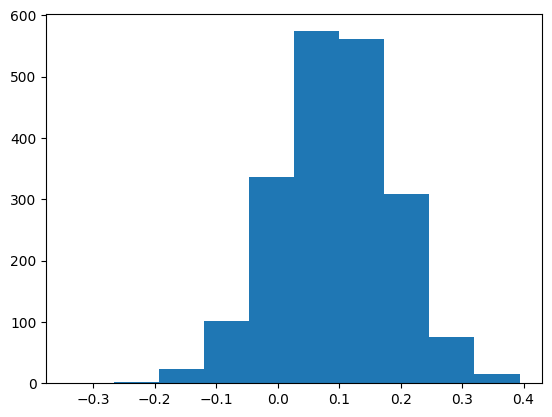

nat     0   -0.015484
Name: nat, dtype: float64


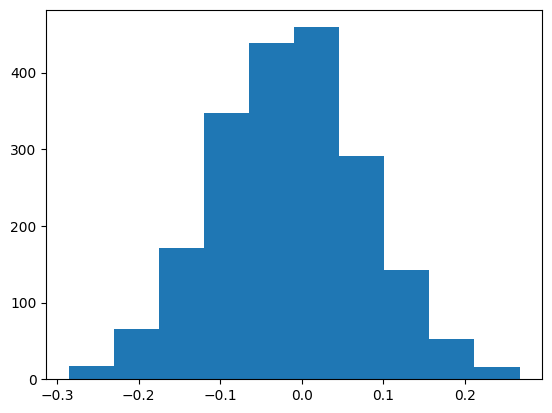

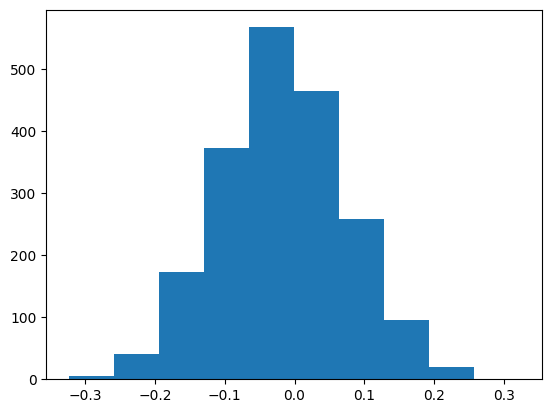

oth     0    0.012374
Name: oth, dtype: float64


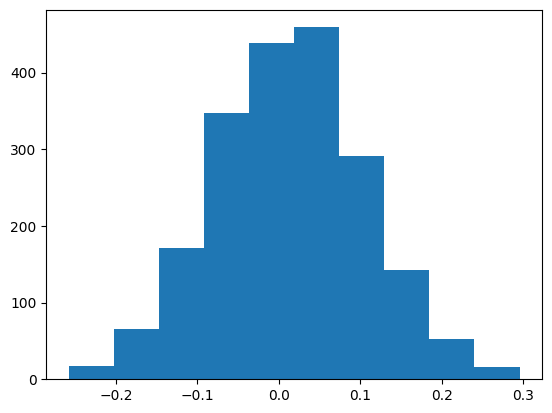

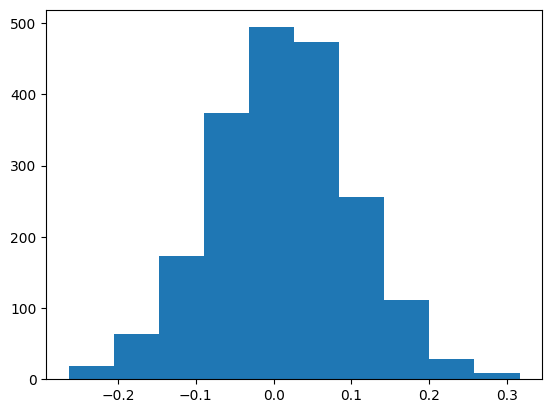

In [8]:
res_path = "outputs/resultsclusteredconstituencies.csv"
n=2000
df = pd.read_csv(res_path)
# poll_avgs = get_poll_avgs()
pc_results = get_results_percentages(df.copy())
pc_res_19 = pc_results[-1]
print(pc_res_19)
constituencies = list(df["New constituency name"])

next_poll_avg = get_weighted_poll_avg(next_url, col_dict=next_col_dict)
nat_polls = standardise_df(next_poll_avg, next_col_dict)
chg_df = nat_polls - pc_res_19
chg_df = chg_df.dropna(axis=1).copy()

natchgs = []
sims_num = n
today = datetime.date.today()
base_seed = int(today.strftime("%d%m%Y%H"))
days_remaining_delta = election_day - today
days_remaining = days_remaining_delta.days
if days_remaining < 1:
    days_remaining = 1
big_future_uncertainty = np.log(days_remaining)*0.008 + days_remaining*0.00015
small_future_uncertainty = np.log(days_remaining)*0.002 + days_remaining*0.0002
print("BigStd: ",big_future_uncertainty+big_std)
print("SmallStd: ",small_future_uncertainty+small_std)
# 09032024 BigStd:  0.11802060145863788



for p in std_parties:
    if nat_polls[p] > 0.2:
        rng = np.random.default_rng(seed=base_seed)
        print(p, "   ", chg_df[p])
        norm = rng.normal(chg_df[p],big_std+big_future_uncertainty,sims_num)
        norm2 = np.random.normal(chg_df[p],big_std+big_future_uncertainty,sims_num)
        natchgs.append(norm)
        plt.hist(norm)
        plt.show()
        plt.hist(norm2)
        plt.show()
    else:
        print(p, "   ", chg_df[p])
        rng = np.random.default_rng(seed=base_seed*2)
        norm = rng.normal(chg_df[p],small_std+small_future_uncertainty,sims_num)
        norm2 = np.random.normal(chg_df[p],small_std+small_future_uncertainty,sims_num)
        natchgs.append(norm)
        plt.hist(norm)
        plt.show()
        plt.hist(norm2)
        plt.show()
clusters = list(set(list(df["Cluster"])))
for p in std_parties:
    for c in clusters:
        if nat_polls[p] > 0.2:
            rng = np.random.default_rng(seed=base_seed*3)
            natchgs.append(rng.normal(0,big_std,sims_num))
        else:
            rng = np.random.default_rng(seed=base_seed*4)
            natchgs.append(rng.normal(0,small_std,sims_num))

chg_dict = {}
i=0
for p in std_parties:
    chg_dict[p+"n"] = natchgs[i]
    i+=1
for c in clusters:
    for p in std_parties:
        chg_dict[p+str(c)] = natchgs[i]
        i+=1
rand_df = pd.DataFrame(chg_dict)

In [2]:
next_poll_avg = get_weighted_poll_avg(next_url, col_dict=next_col_dict)
nat_polls = standardise_df(next_poll_avg, next_col_dict)

In [42]:
next_poll_avg.to_csv("outputs/lastnatpolls.csv", index=False)

In [43]:
last_nat_polls = pd.read_csv("outputs/lastnatpolls.csv")

In [60]:
def polls_have_changed(last_polls_path="UKGE/outputs/lastnatpolls.csv"):
    next_poll_avg = list(get_weighted_poll_avg(next_url, col_dict=next_col_dict))
    last_nat_polls = pd.read_csv(last_polls_path)
    res = False
    for k,v in enumerate(next_poll_avg):
        new_v = round(v,5)
        old_v = round(last_nat_polls.loc[k].iloc[0],5)
        if new_v!=old_v :
            print(k,v,"  ", last_nat_polls.loc[k].iloc[0])
            res = True
    return res

if not polls_have_changed(last_polls_path="outputs/lastnatpolls.csv"):
    print("jj")


jj


In [65]:
def today_results_exist(export_path="UKGE/outputs/EXPORT.csv"):
    export = pd.read_csv(export_path)
    today = datetime.date.today()
    return str(today) in export.columns

True

In [64]:
today

datetime.date(2024, 3, 15)

In [49]:
list(next_poll_avg)

[0.2335,
 0.43166666666666664,
 0.101,
 0.029500000000000002,
 0.0585,
 0.11999999999999998,
 0.02533333333333334]

In [54]:
last_nat_polls.loc[1].iloc[0]

0.4316666666666666

In [41]:
list(last_nat_polls.loc[:,0])

KeyError: 0

In [35]:
list(nat_polls)

[0.2335,
 0.43166666666666664,
 0.101,
 0.029500000000000002,
 0.0585,
 0.11999999999999998,
 0.02533333333333334,
 0.2335,
 0.43166666666666664,
 0.101,
 0.11999999999999998,
 0.029500000000000002,
 0.02533333333333334]

In [30]:
last_nat_polls

,0
0,0.233500
1,0.431667
2,0.101000
3,0.029500
4,0.058500
5,0.120000
6,0.025333
7,0.233500
8,0.431667
9,0.101000


In [ ]:
np.random.normal()